In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re


Load & examine data

In [25]:
tab=pd.read_csv("Weekly_Rates_of_Laboratory-Confirmed_RSV_Hospitalizations_from_the_RSV-NET_Surveillance_System_20251224.csv.gz",compression="gzip").drop_duplicates()
tab

,State,Season,Week ending date,Age Category,Sex,Race,Rate,Cumulative Rate,Type
0,Utah,2022-23,2023-09-30,All,All,All,0.1,78.7,Crude Rate
1,Utah,2022-23,2023-09-23,All,All,All,0.0,78.6,Crude Rate
2,Utah,2022-23,2023-09-16,All,All,All,0.1,78.6,Crude Rate
3,Utah,2022-23,2023-09-09,All,All,All,0.1,78.5,Crude Rate
4,Utah,2022-23,2023-09-02,All,All,All,0.1,78.4,Crude Rate
...,...,...,...,...,...,...,...,...,...
206266,RSV-NET,2025-26 (All Ages),2025-10-18,All,All,"A/PI, non-Hispanic",0.1,0.1,Age adjusted Rate
206267,RSV-NET,2025-26 (All Ages),2025-12-06,All,All,Hispanic,0.5,2.3,Age adjusted Rate
206268,RSV-NET,2025-26 (All Ages),2025-10-25,All,All,Hispanic,0.1,0.3,Age adjusted Rate
206269,RSV-NET,2025-26 (All Ages),2025-11-22,All,All,"AI/AN, non-Hispanic",1.0,1.5,Age adjusted Rate


First, let's subset to data only for total US (not individual states), all sex, all race, and crude rate only.

In [26]:
relevant = tab[
    (tab["State"] == "RSV-NET") &
    (tab["Race"] == "All") &
    (tab["Type"] == "Crude Rate") & 
    (tab["Sex"] == "All")
].drop(columns=["State","Race","Type","Sex"])
# Ensure date column is datetime
relevant["Week ending date"] = pd.to_datetime(relevant["Week ending date"])


In [27]:
relevant

,Season,Week ending date,Age Category,Rate,Cumulative Rate
18720,2022-23,2023-09-30,All,0.7,54.6
18721,2022-23,2023-09-23,All,0.6,53.9
18722,2022-23,2023-09-16,All,0.4,53.4
18723,2022-23,2023-09-09,All,0.4,53.0
18724,2022-23,2023-09-02,All,0.3,52.6
...,...,...,...,...,...
202233,2016-17,2017-04-08,≥65 years,0.4,30.6
202234,2016-17,2017-04-15,≥65 years,0.2,30.8
202235,2016-17,2017-04-22,≥65 years,0.3,31.2
202236,2016-17,2017-04-29,≥65 years,0.3,31.4


It seems that "season" does not directly correspond to year. Let us examine how this breaks down...

In [28]:
relevant["Season"].unique()

array(['2022-23', '2023-24', '2024-25', '2021-22', '2019-20', '2018-19',
       '2020-21', '2025-26', '2017-18', '2016-17'], dtype=object)

In [29]:
len(relevant[relevant["Season"]=="2022-23"]["Week ending date"].unique())

52

Confirmed that one entry is one week.

My understanding is that `rate` is "rate per 100,000" people https://www.cdc.gov/rsv/php/surveillance/rsv-net.html, and "cumulative" is "cumulative for that season". Let us spot-check the latter by making sure cumulative rates add up as expected.

In [30]:
test=relevant[(relevant["Season"]=="2022-23") & (relevant["Age Category"]=="All")]

test = test.sort_values(["Week ending date"])

assert len(test)==52 #making sure this is one entry per week for one season
test.head()

,Season,Week ending date,Age Category,Rate,Cumulative Rate
18771,2022-23,2022-10-08,All,1.6,1.6
18770,2022-23,2022-10-15,All,2.5,4.1
18769,2022-23,2022-10-22,All,2.8,6.9
18768,2022-23,2022-10-29,All,3.6,10.5
18767,2022-23,2022-11-05,All,4.5,15.1


In [31]:
test["Recomputed Cumulative Rate"] = test["Rate"].cumsum()
test["Rounded Rate"] = test["Rate"].round(1)
test["Rounded Cumulative"] = test["Rounded Rate"].cumsum()



In [32]:
test

,Season,Week ending date,Age Category,Rate,Cumulative Rate,Recomputed Cumulative Rate,Rounded Rate,Rounded Cumulative
18771,2022-23,2022-10-08,All,1.6,1.6,1.6,1.6,1.6
18770,2022-23,2022-10-15,All,2.5,4.1,4.1,2.5,4.1
18769,2022-23,2022-10-22,All,2.8,6.9,6.9,2.8,6.9
18768,2022-23,2022-10-29,All,3.6,10.5,10.5,3.6,10.5
18767,2022-23,2022-11-05,All,4.5,15.1,15.0,4.5,15.0
18766,2022-23,2022-11-12,All,5.1,20.2,20.1,5.1,20.1
18765,2022-23,2022-11-19,All,4.6,24.9,24.7,4.6,24.7
18764,2022-23,2022-11-26,All,4.1,28.9,28.8,4.1,28.8
18763,2022-23,2022-12-03,All,4.2,33.2,33.0,4.2,33.0
18762,2022-23,2022-12-10,All,3.4,36.6,36.4,3.4,36.4


In [33]:
all(test["Cumulative Rate"]==test["Recomputed Cumulative Rate"])

False

In [34]:
all(test["Cumulative Rate"]==test["Rounded Cumulative"])

False

This confirms that Cumulative Rate is per season, and summing rates across weeks is basiically valid. The small difference in recomputed cumulative sum and reported cumulative sum is likely due to cumulative sum summing across higher precision internal estimates. Since we want "five years before implementation" I will ignore season and sum across weeks ending in each of 2018-2024 (see main text for explanation of 2018 : five years before changes to vaccien schedule in 2023).

In [35]:
relevant=relevant.drop(columns=["Season","Cumulative Rate"])

Given that the proposed changes to vaccination would potentially abrogate treatments for specific age groups, forcasting the effect requires that we focus on those age groups. Current CDC guidance is 


> CDC recommends RSV vaccination for all adults ages 75 and older and for adults ages 50–74 who are at increased risk of severe RSV.
> To protect infants from severe RSV, CDC recommends an RSV vaccine for pregnant women (Pfizer's Abrysvo) or an infant RSV antibody given to the baby.
> Nirsevimab is also recommended for a small group of young children ages 8–19 months entering their second RSV season. Clesrovimab has not been recommended for this group.

(see [Wayback link: Clinical Overview of RSV](https://web.archive.org/web/20251225014051/https://www.cdc.gov/rsv/hcp/clinical-overview/index.html)).

For this reason, we wish to examine childhood, 50–74, and 75+ cohorts.


In [36]:
relevant["Age Category"].unique()

array(['All', '≥18 years (Adults)', '0-17 years (Children)', '≥75 years',
       '1-4 years', '0-<1 year', '≥85 years', '75-84 years',
       '65-74 years', '40-49 years', '30-39 years', '18-29 years',
       '12-17 years', '5-11 years', '2-4 years', '1-<2 years',
       '6mo-<12 months', '0-<6 months', '≥65 years', '50-64 years',
       '18-49 years', '5-17 years', '0-4 years'], dtype=object)

In [37]:
targets = {
    "0-17 years (Children)",
    "≥75 years",
    "50-64 years",
    "65-74 years",
}

relevant_ages = relevant[
    relevant["Age Category"].str.strip().isin(targets)
]
#relevant_ages=relevant(relevant["Age Category"] in ["0-17 years (Children)", "≥75 years", "50-64 years", "65-74 years"])

In [38]:
relevant_ages

,Week ending date,Age Category,Rate
19188,2023-09-30,0-17 years (Children),2.4
19189,2023-09-23,0-17 years (Children),2.0
19190,2023-09-16,0-17 years (Children),1.4
19191,2023-09-09,0-17 years (Children),1.1
19192,2023-09-02,0-17 years (Children),0.8
...,...,...,...
201945,2017-04-08,≥75 years,0.6
201946,2017-04-15,≥75 years,0.5
201947,2017-04-22,≥75 years,0.4
201948,2017-04-29,≥75 years,0.6


Make sure there is one row per week x age. (This was not the case until i dropped duplicates as a sanitizing step initially...)

In [39]:
assert len(relevant_ages[["Week ending date","Age Category"]].drop_duplicates())==len(relevant_ages)

Merge age cohorts to recap proposed changes

In [40]:
relevant_ages=relevant_ages.copy()

relevant_ages["Age Category"] = relevant_ages["Age Category"].replace({
    "50-64 years": "50-74 years",
    "65-74 years": "50-74 years",
})
relevant_ages

,Week ending date,Age Category,Rate
19188,2023-09-30,0-17 years (Children),2.4
19189,2023-09-23,0-17 years (Children),2.0
19190,2023-09-16,0-17 years (Children),1.4
19191,2023-09-09,0-17 years (Children),1.1
19192,2023-09-02,0-17 years (Children),0.8
...,...,...,...
201945,2017-04-08,≥75 years,0.6
201946,2017-04-15,≥75 years,0.5
201947,2017-04-22,≥75 years,0.4
201948,2017-04-29,≥75 years,0.6


Extract year

In [41]:
relevant_ages["Year"] = relevant_ages["Week ending date"].dt.year
relevant_ages

,Week ending date,Age Category,Rate,Year
19188,2023-09-30,0-17 years (Children),2.4,2023
19189,2023-09-23,0-17 years (Children),2.0,2023
19190,2023-09-16,0-17 years (Children),1.4,2023
19191,2023-09-09,0-17 years (Children),1.1,2023
19192,2023-09-02,0-17 years (Children),0.8,2023
...,...,...,...,...
201945,2017-04-08,≥75 years,0.6,2017
201946,2017-04-15,≥75 years,0.5,2017
201947,2017-04-22,≥75 years,0.4,2017
201948,2017-04-29,≥75 years,0.6,2017


In [42]:
summary = (
    relevant_ages
    .groupby(["Year", "Age Category"], as_index=False)
    .agg(Annual_Rate_per_100k=("Rate", "sum"),
         Weeks_Observed=("Week ending date", "nunique"),
))

summary

,Year,Age Category,Annual_Rate_per_100k,Weeks_Observed
0,2016,50-74 years,7.3,14
1,2016,≥75 years,10.5,14
2,2017,50-74 years,31.5,31
3,2017,≥75 years,59.3,31
4,2018,0-17 years (Children),29.3,13
5,2018,50-74 years,47.7,31
6,2018,≥75 years,93.0,31
7,2019,0-17 years (Children),84.8,31
8,2019,50-74 years,37.8,31
9,2019,≥75 years,68.4,31


In [43]:
recent_subset=summary[summary["Year"]>=2018]
recent_subset

,Year,Age Category,Annual_Rate_per_100k,Weeks_Observed
4,2018,0-17 years (Children),29.3,13
5,2018,50-74 years,47.7,31
6,2018,≥75 years,93.0,31
7,2019,0-17 years (Children),84.8,31
8,2019,50-74 years,37.8,31
9,2019,≥75 years,68.4,31
10,2020,0-17 years (Children),47.7,31
11,2020,50-74 years,27.3,31
12,2020,≥75 years,53.0,31
13,2021,0-17 years (Children),91.0,52


In [44]:
from pathlib import Path

In [45]:
out_dir = Path("tables_svg")
out_dir.mkdir(parents=True, exist_ok=True)

# Ensure nice display formatting
recent_subset = recent_subset.copy()
recent_subset["Annual_Rate_per_100k"] = recent_subset["Annual_Rate_per_100k"].round(1)

for age_cat, sub in recent_subset.groupby("Age Category", sort=True):
    sub = sub.sort_values("Year")[["Year", "Annual_Rate_per_100k", "Weeks_Observed"]]

    # Convert to strings for stable table rendering
    cell_text = [
        [str(int(y)), f"{rate:.1f}", str(int(w))]
        for y, rate, w in sub.itertuples(index=False, name=None)
    ]
    col_labels = ["Year", "Annual rate per 100,000", "Weeks observed"]

    # Figure sizing: scale height with number of rows
    nrows = len(cell_text) + 1
    fig_h = max(1.5, 0.35 * nrows)
    fig, ax = plt.subplots(figsize=(7.0, fig_h))
    ax.axis("off")

    tbl = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        loc="center",
        cellLoc="center",
        colLoc="center",
    )

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.0, 1.25)

    for (row, col), cell in tbl.get_celld().items():
        if row == 0:
            continue  # header
        year_val = sub.iloc[row - 1]["Year"]
        if year_val == 2023:
            cell.set_text_props(weight="bold")

    ax.set_title(f"Annual RSV hospitalization rate per 100,000 — {age_cat}", pad=12)

    # Minimal filename cleanup inline
    fname_age = re.sub(r"[^\w\-]+", "_", age_cat).strip("_")
    fname = out_dir / f"annual_rsv_table_{fname_age}.svg"

    fig.savefig(fname, format="svg", bbox_inches="tight")
    plt.close(fig)

print(f"Wrote SVG tables to: {out_dir.resolve()}")

Wrote SVG tables to: /Users/mcnoon/rsv/tables_svg


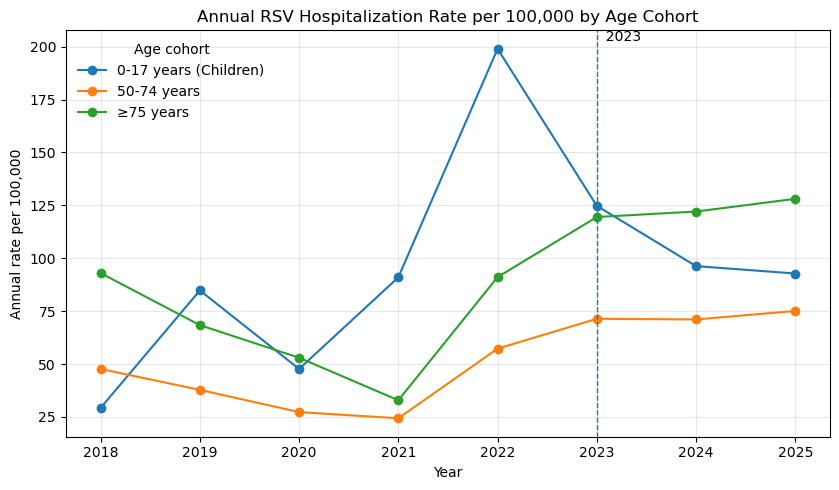

In [46]:
# Ensure sorted years within each cohort
recent_subset = recent_subset.sort_values(["Age Category", "Year"])

fig, ax = plt.subplots(figsize=(8.5, 5.0))

for age_cat, sub in recent_subset.groupby("Age Category", sort=True):
    ax.plot(
        sub["Year"],
        sub["Annual_Rate_per_100k"],
        marker="o",
        label=age_cat,
    )

ax.set_title("Annual RSV Hospitalization Rate per 100,000 by Age Cohort")
ax.set_xlabel("Year")
ax.set_ylabel("Annual rate per 100,000")

ax.grid(True, alpha=0.3)
ax.legend(title="Age cohort", frameon=False, ncol=1)

ax.axvline(2023, linestyle="--", linewidth=1)
ax.text(2023, ax.get_ylim()[1], "  2023", va="top")

plt.tight_layout()
plt.show()